### NLP project on Crunchbase database 

## Contents

&nbsp;&nbsp;&nbsp;&nbsp;**Introduction**   



**1. Data and Preprocessing**    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   1.1. Data Cleaning  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   1.2. First Preprocessing  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   1.3. Removing stopwords using CountVectorizer + Lemmatizing   
**2. Analysis**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    2.1 Word & Document embeddings    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    2.2 TF-IDF Analysis    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    2.3 Topic Modeling with Latent Dirichlet Allocation  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    2.4 Language models      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    2.5 Cluster Analysis    
**3. Models Testing & Conclusions** 

## Introduction


The aim of this research is to derive insights from the analysis of the descriptions that startups (and innovative companies in general) provide of themselves. 


The most important repository of this type of information is Crunchbase: originally built to track only startups, today the website contains information on public and private companies on a global scale. 

Specifically, this project will characterize each company by their name, their description (from now on **overview**) and by the the categorization that is already provided in the dataset. This last element is the main source of information that is going to be analyzed.

In fact, the categories in the dataset are sound but overly specific in the eyes of an investor which is exploring the data looking for new investing opportunities. Due to this, it could be that a company similar to the good-performing ones already in his/her portfolio are mistakenly deemed as completely different. 

Through a rational regrouping and through the results of the main NLP techniques we are going to identify more broad, but equally representative categories for the companies. 

One main limit of the databased used in this project is that the data is not up to date: Crunchbase allows free-of-charge only to download data up to 2013. 
However, the benefit of this framework is that it allows to test the models that have been generated and to assess their validity on unseen, recent overviews. For this reason, the project will include a last section dedicated to this. 




## 1. Data and Preprocessing

###  1.1. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import ngrams

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score




#import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases


import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

from collections import defaultdict
import re





First we load the CSV file and impose that only companies are taken into account

In [2]:
cb_objects = pd.read_csv("data/cb_objects.csv", index_col=0, low_memory=False)
cb_objects = cb_objects[cb_objects["entity_type"] == "Company"]

We only keep most recent startups (those that were funded starting from year 2000) and keep useful columns, for which we drop missing values 

In [3]:
cb_objects.loc[:,('founded_at')] = pd.to_datetime(cb_objects.founded_at, errors='coerce')
cb_objects = cb_objects.loc[(cb_objects.founded_at.dt.year >= 2000),:]
new_columns = ['entity_id','entity_type','normalized_name','category_code','overview', 'status', 'funding_total_usd'  ]
df = cb_objects.loc[:, new_columns ]
df = df.dropna( subset = ['category_code','overview', 'funding_total_usd'])

In [7]:
print("Since there are {} categories of startups, the best idea is to create bigger categories incorporating them".format(len(df.category_code.unique())))

Since there are 42 categories of startups, the best idea is to create bigger categories incorporating them


In [4]:
def merge_categories(categories):
    parent_categories = {
        "information_technology": ["software", "web", "network_hosting", "search", "analytics", "ecommerce"],
        "mobile_app": ["mobile", "social", "messaging","music"],
        "industry": ["hardware", "semiconductor", "manufacturing", "transportation", "automotive", "cleantech","consulting" , "legal", "finance"],
        "health": ["health", "medical", "biotech", "nanotech"],
        "entertainment": ["games_video","sports", "photo_video", "pets", "news", "design", "fashion", "travel", "hospitality","public_relations","advertising"],
        "other": ["other", "enterprise", "local", "nonprofit", "government", "security", "education", "real_estate"]
    }
    mapping = {v: k for k,vv in parent_categories.items() for v in vv}

    return categories.map(mapping)
df["category_code"] = merge_categories(df["category_code"])

By looking at the new categories it is evident that there is a prevalence of Startups operating in the Information Technology field.  


This is justified by the technological innovations that have taken place in the past decades. However, this "inbalance" does not represent a problem for our analysis. In fact, the presence of IT tools (and thus of words related to it inside overviews) is nowadays sufficiently common in all field; by preprocessing and removing most common words across documents we make sure that they are not biasing our result. 

In [9]:
df["category_code"].value_counts()

information_technology    6976
entertainment             2916
health                    2434
other                     2303
mobile_app                2264
industry                  2199
Name: category_code, dtype: int64

Let's plot the distribution of Overviews into the new categories

<BarContainer object of 6 artists>

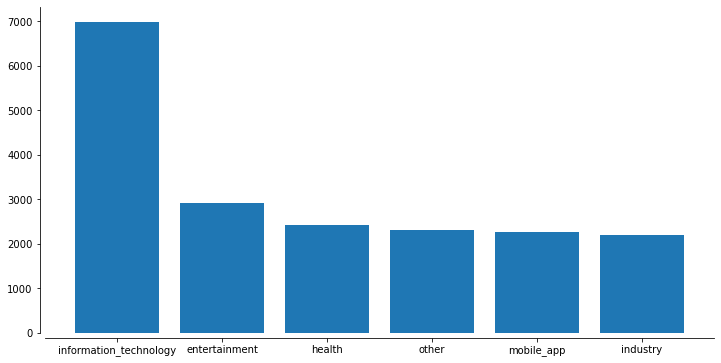

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

category_counts = df["category_code"].value_counts()
labels = category_counts.index.tolist()
sizes = category_counts.values.tolist()
plt.bar(labels, sizes)

One last piece of information that can be introduced is the amount of capitalization obtained by the company. 

To do so, we introduce a categorical variable called "funding_category" and reindex our Dataframe df dividing each comany in:


I. Biggest size companies: funding amount > $ 100.000K  

II. Medium size companies: 100K < funding amount < $ 100.000K 


III. Smaller size companies: funding amount < $100K 

In [5]:
df_visual = df.copy(deep=True)

In [6]:
filter_method = lambda x: 'I' if x >= 100000000 else 'II' if (x < 100000000 and x >= 100000) else 'III' if x < 100000 else None
df_visual["funding_category"] = df_visual["funding_total_usd"].apply(filter_method)
pd.DataFrame(df_visual["entity_id"].groupby([df_visual["funding_category"],df_visual["category_code"]]).count()).rename(columns={'entity_id':'number'})

number
funding_category category_code                 
I                entertainment               42
                 health                     106
                 industry                    94
                 information_technology      88
                 mobile_app                  37
                 other                       42
II               entertainment             2525
                 health                    2222
                 industry                  1960
                 information_technology    6103
                 mobile_app                1904
                 other                     2026
III              entertainment              349
                 health                     106
                 industry                   145
                 information_technology     785
                 mobile_app                 323
                 other                      235

To better visualize the result we use a bar plot:

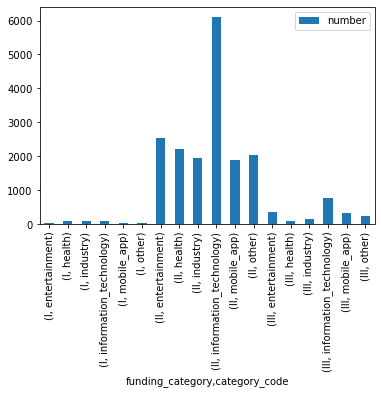

In [7]:
pd.DataFrame(df_visual["entity_id"].groupby([df_visual["funding_category"],df_visual["category_code"]]).count()).rename(columns={'entity_id':'number'}).plot(kind= "bar")

As it could be expected we can almost see a gaussian distribution of the companies across the two indices. The predominance of the technology category is confirmed in all three funding ranges. 

Moreover, even though the great majority of companies belongs to the II category, there is an interesting skewedness toward the right side. This asymmetry is due to an intrinsic bias of the database: obviously, the biggest companies are more likely to be featured on the database rather than the smallest startups, that are, therefore, absent in this representation.


###  1.2. First Preprocessing 

By printing out the first overviews it is clear that there is some noise. Some examples are numers, website links and connected words (meta-network, state-of-the-art) that would be meaningful separately.


Our aim is to use regular expressions clean this elements. A copy called df2 is kept in order to create statistics at the end of the preprocessing. 

In [8]:
df2 = df.reset_index( drop = True).drop(columns = ["entity_id"])

In [9]:
for i in range(2):
    pprint(df2.iloc[i][['normalized_name','overview']].values)

array(['wetpaint',
       'Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaint'],
      dtype=object)
array(['friendfeed',
       "[FriendFeed](http://www.friendfeed.com) aims to be a one stop shop for all your social networking updates and news items.  The four founders were all team members at [Google](/company/google) and helped to launch such products as [Google Maps](/product/google-maps), [Adsense](/product/google-adsense), [GMail](/product/gmail) and [Google Groups](/product/google-groups).  They've brought their expertise to a slightly different area: social network aggregating.\r\n\r\nFriendFeed is a service which, instead of layering a meta-network on top of all your other social networks, will create a news feed incorporating them all much like the [Facebook](/company/facebook) news feed.  \r\n\r\nUsers tell the feed which networks they b

In [10]:
def text_cleaner(text):
    """Removes emails, urls, text in parentheses, and \r or \n.
       Replace dashes in words with spaces(e.g. easy-to-use > easy to use)"""
    text = re.sub('\S*@\S*\s?', '', text)     # remove twitter handles / emails 
    text = re.sub('\(.*?\)','', text)         # Remove words in parenthesis
    text = re.sub('\[.*?\]','', text)         # Remove words in parenthesis
    text = re.sub('\\n|\\r','',text)          # Remove "\n or \r"
    text = re.sub('(?<=\S)-',' ', text)       # Replace - in words with spaces
    text = re.sub('[_\-\'\"]+\S+', '', text)  # remove words that start with punctuation
    text = re.sub('\S*[0-9]+\S*', '', text)   # remove words with numbers
    return text

In [11]:
df2['overview'] = df2['overview'].apply(text_cleaner)

### 1.3 Removing stopwords using CountVectorizer + Lemmatizing 

In this second phase we first aim to remove stopwords. 

Instead of merely relying on the standard  ones offered in the sklearn library,it is possible to personalize this list by adding those words that do not convey any important message.   
Technically, this is automatically done by setting thresholds inside the CountVectorizer and TFIDF functions. However, the structure of this corpus is such that some words could be repeated very often in a specific subset (such as the word "media" for the companies operating in the Entertainment industry). Those words would not be detected since they do not appear in more than the 75% of the corpus (for example).   

Using CountVectorized with no maximum frequence limit allows to find these words.

In [12]:
clean_df = df2[['normalized_name','overview','category_code']].set_index('normalized_name')

In [13]:
cv = CountVectorizer(stop_words='english')                  
X_cv_preliminar = cv.fit_transform(clean_df.overview)                 
overview_dtm = pd.DataFrame(X_cv_preliminar.toarray(), columns=cv.get_feature_names())
overview_dtm.index = clean_df.index

Here add the 25 most frequent words to the list of specific stops and print them for clarity

In [14]:
specific_stops = list(overview_dtm.sum().sort_values(ascending=False)[:25].index)
specific_stops

['company',
 'based',
 'mobile',
 'platform',
 'online',
 'technology',
 'provides',
 'social',
 'services',
 'data',
 'solutions',
 'founded',
 'software',
 'products',
 'users',
 'new',
 'service',
 'business',
 'offers',
 'management',
 'web',
 'time',
 'content',
 'media',
 'world']

Now, after removing the stopwords we lemmatize words. 

Since the overviews are the presentations of companies that aim to obtain funds from investors, their style is similar, refined and technical. We not only assume that lemmatizing does not imply any loss of information lost, but, moreover, that this procedure allows to better understand underlying similarities. 


Finally we create the final DataFrame, Called clean_df. 

In [15]:
lemmatizer = WordNetLemmatizer()
def lemmatize_stemming(text):
    return lemmatizer.lemmatize(text, pos='v')
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in specific_stops and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [16]:
clean_df['overview'] = clean_df['overview'].apply(preprocess)

### 1.4 Statistics about preprocessing

In [26]:
words_before = " ".join(df['overview'].to_list()).split()

In [27]:
words_after = " ".join(clean_df['overview'].to_string()).split()

In [28]:
print( "The number of all the companies in the dataframe was of {};".format(len(cb_objects)))
print( "After removing the ones with missing values in the analysis-relevant attributes we reached a dataframe of size {} \n".format(len(clean_df)))
print( "The corpus contained {} words before the preprocessing:".format(len(words_before)))
print( "After removing stopwords we have {} lemmatized words.\n".format(len(words_after)))
print( "Lastly, the average lenght of an overview before preprocessing was {}, while the average lenght of an overview after performing the preprocessing is of {} words. \n".format((round(len(words_before) / len(df), 2)),round(len(words_after) / len(clean_df), 2)))

The number of all the companies in the dataframe was of 78696;
After removing the ones with missing values in the analysis-relevant attributes we reached a dataframe of size 19092 

The corpus contained 1459710 words before the preprocessing:
After removing stopwords we have 1026392 lemmatized words.

Lastly, the average lenght of an overview before preprocessing was 76.46, while the average lenght of an overview after performing the preprocessing is of 53.76 words. 



## 2. Analysis 

### 2.1 Word and Document Embeddings 

In order to create Word Embeddings, we re-implement CountVectorizer, this time introducing the best parameters for the corpus

In [17]:
vectorizer = CountVectorizer(analyzer='word',
                             stop_words='english',
                            # ngram_range=(1, 2), # still use unigrams and bigrams
                             min_df=0.001, # use only n-grams occuring in at least 0.1% of docs
                             max_df=0.75) # use only n-grams occuring in max 75% of docs
  
corpus_cv = clean_df.overview.to_list()

In [18]:
w2v_model = Word2Vec(size=100, # vector size
                     window=15, # window for sampling
                     sample=0.0001, # subsampling rate
                     iter=200, # iterations
                     min_count=100, # minimum threshold
                     workers=10, # parallelize to all cores
)

# build the vocabulary
w2v_model.build_vocab(corpus_cv)

# train the model
w2v_model.train(corpus_cv, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)


(48062817, 146707800)

In [19]:
w2v_model.wv.most_similar(['help'])

[('better', 0.6738294363021851),
 ('empower', 0.6182574033737183),
 ('decisions', 0.5619518160820007),
 ('understand', 0.5228228569030762),
 ('businesses', 0.43285495042800903),
 ('relationships', 0.4134939908981323),
 ('opportunities', 0.41277778148651123),
 ('make', 0.41166919469833374),
 ('believe', 0.41045305132865906),
 ('spend', 0.39624330401420593)]

The words associated belong to 2 categories. Some are related in the use case (help and businesses, others are semantically synonims (Help, improve and better). Also the similarity between two words is sound.  

In [32]:
print(w2v_model.wv.similarity("help", "enhance"))

0.07105984


In [33]:
print(w2v_model.wv.similarity("help", "drop"))

8.6475164e-05


One way to represent this analysis graphically is by using the dimension reduction (specifically t-SNE). 

It must be specified that the best practice is to use dimension reduction with sparce matrices (not the case w2v). However, if we take into account that some information is lost in the process and that the relative distances are not precise, this view can still be useful to give an idea of how the words are distributed. 

In particular, it is confirmed that the words in the vocabulary are pretty much comparable and similar, and therefore only a limited amount has vectors significately far from the others.

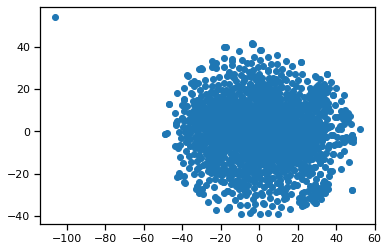

In [34]:
sb.set_context('notebook')

Z = w2v_model.wv[w2v_model.wv.vocab]

tsne = TSNE(n_components=2)
Z_tsne_w2v = tsne.fit_transform(Z)

plt.scatter(Z_tsne_w2v[:, 0], Z_tsne_w2v[:, 1])
plt.show()

Now we implement the Doc2Vec representation 

In [35]:
corpus_d2v = []

for row in clean_df.iterrows():
    label = row[1].category_code
    text = row[1].overview
    corpus_d2v.append(TaggedDocument(words=text, 
                                 tags=[str(label)]))

In [ ]:
d2v_model = Doc2Vec(vector_size=100, 
                    window=15,
                    #hs=0,
                    #sample=0.000001,
                    #negative=5,
                    min_count=40,
                    workers=10,
                    epochs=10,
                    #dm=1, 
                    dbow_words=1                    
                   )

d2v_model.build_vocab(corpus_d2v)

d2v_model.train(corpus_d2v, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

We can use the model to find the most similar categories. The first result to be shown for each target_doc , which is the most similar category, are intuitive to interpret: The health and industrial category are the most similar due to the more "technical" lexicon required in their description compared with the more "marketing & communication" one used by startups in the entertainment or mobile app. 

On the other hand it is harder to understand the categories that come second, which more likely require a more profound analysis in the style.

In [ ]:
target_doc = 'industry'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=2)
print(similar_docs)

In [ ]:
target_doc = 'health'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=2)
print(similar_docs)

In [ ]:
target_doc = 'entertainment'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=2)
print(similar_docs)

In [ ]:
target_doc = 'information_technology'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=2)
print(similar_docs)

In [ ]:
target_doc = 'other'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=2)
print(similar_docs)

In order to understand more it is useful to retrieve the most similar words per each of those "unexpectedly similar" categories, such as health and mobile_app. Even a loger list can be retrieve in other to search similarity by changing the "topn" variable, but the result is always the same: 

In [ ]:
d2v_model.wv.most_similar([d2v_model.docvecs['health']], topn = 5)

In [ ]:
d2v_model.wv.most_similar([d2v_model.docvecs['mobile_app']], topn = 5)

The doc2vec model is correctly working since the words displayed indeed are the most similar to each category, but there is no noticeable similarity between the two lists that would explain the result of the most_similar method. This is the main limit of continuous representations: they are not intepretable in each dimension of the vectors, so we cannot further investigate them with the aim of finding a causal explanation of the phenomenon. 

We can conclude that the similarity across categories is only partially addressed by the doc2vec model by finding coherently only the main similar category to the one provided

Also in this case the graphical representation through dimension reduction gives only an "intuitive" representation and is to be intepreted with the caveats specified above

In [ ]:
doc_matr = d2v_model.docvecs.vectors_docs
k = 2

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(doc_matr)

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
plt.scatter(U[:,0], U[:,1])
for i, txt in enumerate(list(d2v_model.docvecs.doctags.keys())):
     plt.annotate(txt, (U[i,0]+0.0005, U[i,1]+0.0005))
        

### 2.2 TF-IDF Analysis

TF-IDF allows to identify the most important words in the corpus avoiding the bias that using the mere frequence would present. Regarding the parameters, we still chose a relatively high maximum presence of the words in order to remove terminology related to the existence of the company rather than the industry in which it is operating. 

Sublinear  = True is fundamental because it will allow us in the last section to analyze new overviews that include words that do not occur in the original corpus.  

In [20]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True)

X_tfidf = tfidf_vectorizer.fit_transform(df2.overview.to_list())



Visualization is useful to understand what is actually happening using tfidf_vectorizer. 
We represent the tf-idf on the x axis, which is the new "score" which is assigned to each word. The idf (inverse of the document frequency) is represented on the y axis and is the weight that allows to remove words that appear intensively in the whole corpus. Finally, the size of the points is proportional to the term frequency. 


Instead of focusing on specific words and adding labels, it is interesting to analyze the general trend. The great majority of words in the corpus are regarded with a low score, except for few that have a good trade-off between their raw frequency and the idf, which appear with larger points on the lower-right part of the graph.

In [ ]:
X_cv = vectorizer.fit_transform(df2.overview.apply(str).to_list()) 

word_counts = X_cv.toarray()
word_tfidf = X_tfidf.toarray()

df_tfidf = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
                                'tf': word_counts.sum(axis = 0),
                                'idf': tfidf_vectorizer.idf_,
                                'tfidf': word_tfidf.sum(axis=0)})

df_tfidf = df_tfidf.sort_values(['tfidf','tf','idf'])

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

df_tfidf['tf'] /= 10

df_tfidf.plot.scatter( x = 'tfidf',
                        y = 'idf',
                        s = np.array(df_tfidf['tf']),
                        ax = ax,
                        alpha = 0.3,
                        edgecolor = 'k',
                        ylim = (2,8),
                        xlim = (0,400)
                     )

###  2.3 Topic Modeling with Latent Dirichlet Allocation

Now we reach the most informative part of this analysis. We start by implementing a dictionary and a Bag of Words in order to prepare the optimal corpus for Topic Modeling.

In [21]:
processed_overviews = clean_df.overview.to_list()
dictionary = Dictionary(processed_overviews)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_overviews]
tfidf = models.TfidfModel(bow_corpus) 
model_corpus = tfidf[bow_corpus] 

The next step is finding the best number of topics by evaluating coherence through Cross Validation.


**Warning:         
the following cell requires more time to be implemented. It is suggested to procede directly to the implementation of the LDAmodel**

In [22]:
coherence_values = []

dev_size = 15000

for num_topics in range(2, 15):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=processed_overviews[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')


    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, cv_score)
    coherence_values.append((num_topics,cv_score))

2 0.3484167406426366
3 0.36615716019952943
4 0.3713901132565101
5 0.3866152419584552
6 0.36738295514653485
7 0.361010326819962
8 0.34574945386431166
9 0.3578930788355431
10 0.34916934089125135
11 0.33392774263954267
12 0.35493465185206646
13 0.36408840115952157
14 0.3591974983320965


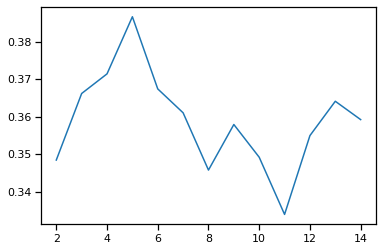

In [23]:
%matplotlib inline
sb.set_context('notebook') # use large font
scores = pd.DataFrame(coherence_values, columns=['num_topics','CV'])
plt.plot(scores['num_topics'], scores['CV']);

Interestingly, the optimal number found by the model is 5. This is not significantely different from our initial re-arranging of categories into 6 "Macro" ones. However, even if the number that resulted had been 6 it still did not imply that our preliminary discrimination was correct. In fact, the topics identified by the model are not directly linked to the traditional ones

This is indeed important to further develop and thus we procede by implementing the model and finding the descriptors for each of the topics. 

In [31]:
num_topics = 5
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200

model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus,  
                     id2word=dictionary, 
                     workers= 10, 
                     passes=num_passes, 
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=71
                    )

In [34]:
#71
topic_sep = re.compile("0\.[0-9]{3}\*") # removing formatting

model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=10)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:4]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "energy", "cloud", "card", "power"
2 "health", "help", "healthcare", "care"
3 "game", "industry", "developers", "market"
4 "develop", "development", "systems", "technologies"
5 "share", "people", "brand", "create"


Rather than focusing on the specific words it is interesting to point out that the main descriptors do not answer to the question "What does this startup do? / How does this startup operate", which would seem logical. On the contrary it seem to answer to the question: "Which services / product does this company offer to their client?". Except for the first category, which is a bit ambiguous, we can see "care" , "game", "development"; "share". 

This is an important insight on the type of communication on the platform. Next, we attempt to find an approximation of each of this topics that allows for more clarity in the final section.

In [35]:
topic_names = {1:'Industry',
                2:'Healthcare',
                3:'Games',
                4:'IT',
                5:'Marketing',
              
}

We now define a function that returns for a given Overview its text and the topics associated with it. 

In [36]:
def lda_topic(new_text): 
    print(new_text)
    print("                                 ")
    bag = dictionary.doc2bow(new_text)
    for index, score in sorted(model[bag], key=lambda tup: -1*tup[1]):
        print("Topic: {} \nScore: {} \t \n ".format(topic_names[index+1], score)) 

And try it on a random startup in the corpus 

In [37]:
lda_topic(clean_df.loc['cartera commerce','overview'])

['cartera', 'commerce', 'lead', 'provider', 'card', 'link', 'market', 'increase', 'revenue', 'customer', 'loyalty', 'merchants', 'bank', 'issuers', 'loyalty', 'program', 'merchants', 'cartera', 'power', 'industry', 'largest', 'card', 'link', 'advertise', 'network', 'target', 'shop', 'million', 'loyal', 'consumers', 'track', 'store', 'sales', 'bank', 'issuers', 'loyalty', 'program', 'cartera', 'industry', 'comprehensive', 'card', 'link', 'offer', 'power', 'personalize', 'store', 'shop', 'program', 'build', 'consumer', 'engagement', 'maximize', 'card', 'spend', 'create', 'revenue', 'stream', 'cartera', 'deliver', 'card', 'link', 'multiple', 'digital', 'market', 'channel', 'include', 'websites', 'bank', 'email', 'browser', 'apps', 'largest', 'financial', 'institutions', 'largest', 'airlines', 'merchant', 'advertisers', 'drive', 'incremental', 'revenue', 'cartera', 'fully', 'manage', 'performance', 'headquarter', 'lexington', 'significant', 'operations', 'atlanta']
                        

In the last section of this project we will apply it to unseen documents.

###  2.4 Language Models

In this case, for the corpus generation, we refer to the DataFrame df2, since we are interested in whole sentences and not in lists of lemmatized words such as those that are included in clean_df.

In [42]:
corpus_lm = [line.strip().split() for line in df2.overview.to_list()]

Let's implement the model and compute the logProbability that a sentence belongs to the corpus of company overviews 

In [43]:
smoothing = 0.001
START = '_***_'
STOP = '_STOP_'
counts = defaultdict(lambda: defaultdict(lambda: smoothing))
for sentence in corpus_lm:
    tokens = [START, START] + sentence + [STOP]
    for u, v, w in ngrams(tokens, 3):
        counts[(u, v)][w] += 1
def logP(u, v, w):
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))
def sentence_logP(S):
    tokens = [START, START] + S + [STOP]
    return sum([logP(u, v, w) for u, v, w in ngrams(tokens, 3)])

In [44]:
sentence_logP('Cardiosolutions was founded in  by STD Med, Inc., a leading medical device manufacturer, in order to develop less invasive alternatives to open surgical procedures addressing the mitral valve of the heart'.split())

-80.76587894270321

In [45]:
sentence_logP(['the', 'company', 'is', 'not','efficient', 'and', 'it', 'should', 'not', 'be', 'awarded', 'with', 'any', 'funding'])

-98.01038802437583

We can see that language models seem to be able to provide a measure of the likelihood of a sentence. However, it is clear that the  measures of the scores should not be interpreted as relative distances. In fact, when providing an overview which is indeed inside the corpus and comparing it with a random text, the first one does not receive a significantly "better" score. This represents one of the main limits of our analysis up to now and therefore the sentence likelihood analysis of new Overviews will not be included in th final section. 

###  2.4 Cluster Analysis

Our last analysis consists in Clustering the data, investigating whether the grouping is somewhat similar to the one resulting from topic modeling. One important clarification is that Cluster Analysis is implemented recurring to dimensionality reduction in order to speed up the process. Therfore, our analysis will take into account the loss of information. 

We start by preliminarly defining a function that allows to plot the clusters

In [46]:
sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    fig = plt.figure(figsize=(10,10))
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)
    cm = plt.get_cmap('winter') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        df['z'] = vectors[:,2]
        sb.set_context('paper')
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])


        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        sb.set_context('talk')
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
     plt.legend()
    plt.show()

The best number of clusters can be chosen based on the Silhouette method.
**Warning : The following cell requires more time**
The first code of section 2.2 must be runned in order to provide the X_tfidf matrix

In [50]:
X2 = TruncatedSVD(n_components=50).fit_transform(X_tfidf)
sample = np.random.choice(len(X2), replace=False, size=8000)

silhouettes = []

K = range(2, 10)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    


2 0.03869976210777165
3 0.04262595007767228
4 0.04361534893624308
5 0.04803688259057936
6 0.029847766758380714
7 0.032290809892312845
8 0.036927517355633314
9 0.03873025256324724


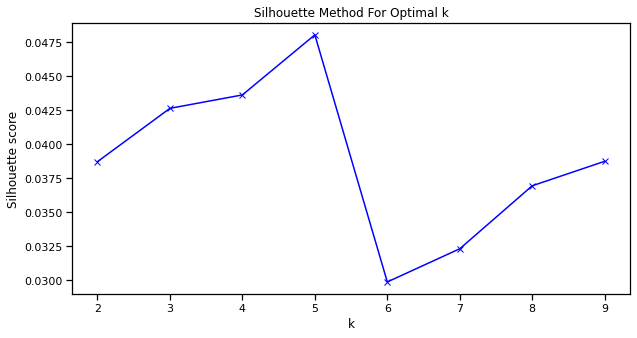

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

It is interesting to see that also the optimal number of clusters is 5. To better undestand the result we find these clusters and visualize them. To do so, we first run Agglomerative Clustering to identify the centroids that will represent the input for the k-means algorithm.


In [52]:
k = 5

# We reduce the dimensionality of the input, to speed up clustering
X2 = TruncatedSVD(n_components=300).fit_transform(X_tfidf)

agg = AgglomerativeClustering(n_clusters=k)

In [53]:
sample = np.random.choice(len(X2), replace=False, size=8000)
agg_sample_ids = agg.fit_predict(X2[sample])

In [54]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(5, 300)


In [55]:
km = KMeans(n_clusters=k, 
            n_init = 1,
            init=centroids)

# fit it on the full data set
km.fit(X2)

KMeans(init=array([[ 0.134535  , -0.04389081,  0.01027786, ...,  0.00032192,
        -0.00020603,  0.00045842],
       [ 0.12133416,  0.14267805,  0.10120784, ...,  0.00096533,
        -0.00030372,  0.00123507],
       [ 0.09437071, -0.10264383,  0.08640365, ..., -0.00493992,
        -0.00396126,  0.00550196],
       [ 0.1543757 ,  0.05267031, -0.03063349, ..., -0.00028143,
         0.00019653, -0.00071889],
       [ 0.15088932, -0.05650898,  0.09041123, ..., -0.00104454,
        -0.00252272, -0.00080625]]),
       n_clusters=5, n_init=1)

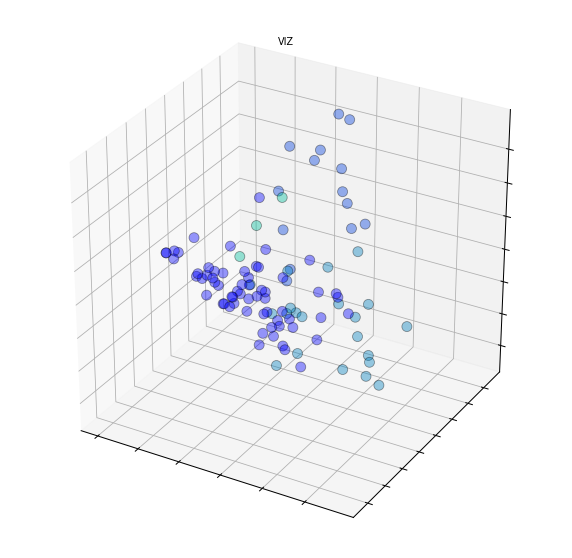

In [56]:
plot_sample = np.random.choice(len(X2), replace=False, size=100)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

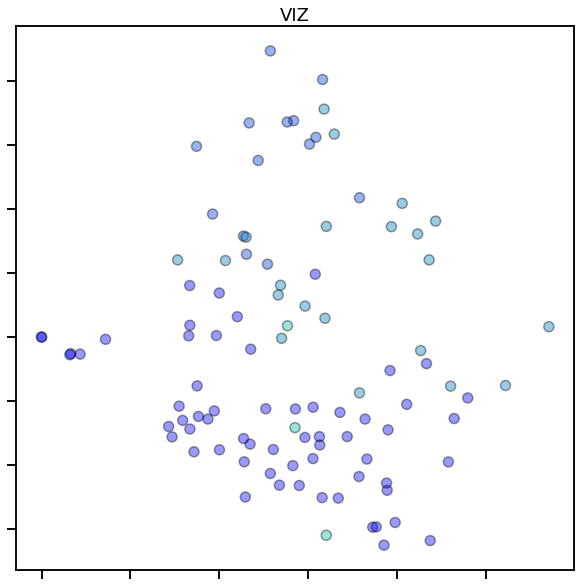

In [57]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2, )

From the visualization it can be seen that the categories are surely intertwined, but also sufficienlty distinguishable . However, it must be ept in mind that dimension reduction has taken place, so the representation might not be completely sound.

One last consideration is that the resut of the Clustering is coherent with the result of topic analysis, in the sense that the corpus is divided into 5 categories, as we visually represented above. 

## 3. Models Testing & Conclusions

Let's start the final testing of our models with one of the most interesting uses of tf-idf, which is is to find the most indicative words inside unseen new overviews. 


In [58]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())


new_doc = ["Contentyze develops a content generation platform, merging deep learning research with commercial applications in marketing, media and e-commerce.",
           'Balance is an enterprise social software platform to help personal finance professionals collaborate and engage with their clients to more efficiently manage financial tasks.']
responses = tfidf_vectorizer.transform(new_doc)


def get_top_tf_idf_words(response, top_n=3):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]
  
print([get_top_tf_idf_words(response,3) for response in responses])

[array(['deep', 'learning', 'commercial'], dtype='<U18'), array(['balance', 'tasks', 'collaborate'], dtype='<U18')]


As it can be seen the model is able to grasp the most important words. In the first case we have the deep-learning and commercial, thus understandin the technologies used but also the aim of the business. 
In the second case it identifies the name and the most important features of the service offered by the company.

Next, we use Language Models to generate new Overviews.

In [59]:
def generate():
    result = [START, START]
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)
    while next_word != STOP:
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)    
    return ' '.join(result[2:-1])

def sample_next_word(u, v):
    keys, values = zip(*counts[(u, v)].items())
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position
    return keys[np.argmax(sample)]

In [60]:
generate()

'SPOOFEM.COM is a web hosting control panel with tightly integrated with popular advertising networks and apps, creating a \x93virtual endcap\x94 anywhere that product reviews by genuine holiday makers allow the community to contribute - no longer required to enable rapid detection of autism. Autism Spectrum Disorders. This perplexing neurologic condition is believed to be granted with additional offices in Alexandria, Va., with offices in Denmark where the sand drops out inside the corporation to understand the sensory experience conducive to wellness and fun. The Influitive vision is to redefine the state of the core of the millions suffering from inflammatory bowel disease and allergic rhinitis. Within the Company have worked in social media. Smarps main product, FitOrbit, is an EPC provider of interconnection, colocation and private investors to fund its future product developments.The company products are mainly in the cloud. CloudHealth allows companies to launch core titles, eac

From different attempts it can be inferred that most artificially-generated overviews include:  
    **Value proposition  & Product description** (both always reproduced by the function)  
    **Geographical locations** (sometimes present)  
One crucial downside is that the Company categorization is not taken into account, therefore different topics (healthcare, advertising, high-tech) are mixed. One solution could be creating sub-corpuses and train the model on each of them 
    

Lastly, we also apply the Topic Model to recently added StartUps, one operating in healthcare and the second in applied IT. 

In [65]:

text1 = """Babylon is a digital health service provider that combines AI technology with the medical 
expertise of humans. Babylon delivers full access to healthcare, including personalized health assessments, 
treatment advice, and face-to-face appointments with a doctor 24/7. Babylon’s mission is to put an accessible 
and affordable health service in the hands of every person on earth. With the Babylon app, you can talk to a 
physician within minutes via phone or video call, ask simple medical questions via their text service and monitor 
your health with their comprehensive tracking system. The Babylon app is everything you need to 
proactively manage your healthcare."""

text2 = """
Contentyze develops a content generation platform, integrating cutting edge deep learning research with commercial applications in marketing and e ommerce.
"""


In [66]:
text1_p = preprocess(text1)
text2_p = preprocess(text2)

In [67]:
lda_topic(text1_p)

['babylon', 'digital', 'health', 'provider', 'combine', 'medical', 'expertise', 'humans', 'babylon', 'deliver', 'access', 'healthcare', 'include', 'personalize', 'health', 'assessments', 'treatment', 'advice', 'face', 'face', 'appointments', 'doctor', 'babylon', 'mission', 'accessible', 'affordable', 'health', 'hand', 'person', 'earth', 'babylon', 'talk', 'physician', 'minutes', 'phone', 'video', 'simple', 'medical', 'question', 'text', 'monitor', 'health', 'comprehensive', 'track', 'babylon', 'need', 'proactively', 'manage', 'healthcare']
                                 
Topic: Healthcare 
Score: 0.7542299032211304 	 
 
Topic: Marketing 
Score: 0.19220156967639923 	 
 
Topic: IT 
Score: 0.02399209514260292 	 
 
Topic: Industry 
Score: 0.016681738197803497 	 
 
Topic: Games 
Score: 0.012894679792225361 	 
 


In [68]:
lda_topic(text2_p)

['contentyze', 'develop', 'generation', 'integrate', 'cut', 'edge', 'deep', 'learn', 'research', 'commercial', 'applications', 'market', 'ommerce']
                                 
Topic: IT 
Score: 0.6327376365661621 	 
 
Topic: Healthcare 
Score: 0.2063627392053604 	 
 
Topic: Games 
Score: 0.060650598257780075 	 
 
Topic: Industry 
Score: 0.05301868915557861 	 
 
Topic: Marketing 
Score: 0.04723035544157028 	 
 


It can be seen that the model, at least in the first result shown, is correct.

In conclusion, we have reached an in depth understanding of the CrunchBase database. Companies tend to use similar style and transfer common information in their description, exactly as expected. However, also new unexpected insights were found: 
Topic models were able to identify recurring topics that allow us to find sub-categories of companies, which are not exactly industry-related. There is a much bigger focus on the value proposition of the Company, showing how the most recent approach in business is customer-centric
Moreover, also clustering has confirmed a remarked differentiation inside the corpus.

Future analysis could include:
- the matching of investors that have already invested in some of the startups in this database with similar ones.
- The identification of correlation between similar overviews and total_funding received